In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import os, sys
sys.path.append('/home/ibecker/Dropbox/MyPythonClasses/FinalClass/')

import Classifier.Model_53.Multiband_53 as multiband
import BaseClass.plot_v2 as plot
from sklearn.metrics import f1_score

In [2]:
# To reset cuda
# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm
# To see if the system regognises the GPU
device = 0
devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[device], 'GPU')
tf.config.experimental.set_memory_growth(device=devices[device], enable=True)


2023-05-03 14:28:59.136096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 14:28:59.136326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 14:28:59.140918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 14:28:59.141108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 14:28:59.141277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Read the TF-records of the test sets. Compute the mean magnitudes and final classification using the Functional API.

In [3]:
survey = 'Gaia'
label_order = ['CEP', 'T2CEP', 'MIRA_SR','RRAB', 'RRC', 'DSCT_SXPHE']

path = os.path.join('../03_Train_Models/', survey, 'Results/Fold_*',)
folds = glob(path)
folds.sort()
folds

['../03_Train_Models/Gaia/Results/Fold_1',
 '../03_Train_Models/Gaia/Results/Fold_2',
 '../03_Train_Models/Gaia/Results/Fold_3',
 '../03_Train_Models/Gaia/Results/Fold_4',
 '../03_Train_Models/Gaia/Results/Fold_5',
 '../03_Train_Models/Gaia/Results/Fold_6',
 '../03_Train_Models/Gaia/Results/Fold_7']

In [4]:
folder_name = 'Results'

In [5]:
# Containers to store the results
reports_folds = []
cm_folds = []
for fold in folds:
    tf.keras.backend.clear_session()
    # Set the fold path
    base_dir = fold+'/'
    
    # Get the last run
    path_runs_folder = os.path.join(base_dir, 'Models', '*')
    path_runs = glob(path_runs_folder)
    path_runs.sort()
    path_run = path_runs[-1]    
    
    path_preprocess = fold.replace('/03_Train_Models/', '/02_Create_Records/').replace('/'+folder_name+'/', '/Folds/')
    test_files = os.path.join(path_preprocess, 'test/*.tfrecord')
    path_preprocess = os.path.join(path_preprocess, 'metadata_preprocess.json')    

    
    new = multiband.Network()    
    settings_path = os.path.join(path_run, 'all_settings.json')

    fold_name = fold.split('/')[-1]
    write_path = os.path.join('./'+folder_name, fold_name+'_Results.dat')
    
    # Get weights path
    run = path_run.split('/')[-1]
    weights_path = os.path.join(fold, 'Models', run)
    new.run_test(settings_path, test_files, weights_path, df_paths = None);

    break

2023-05-03 14:28:59.748667: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 14:28:59.750047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 14:28:59.750771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 14:28:59.751506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

../02_Create_Records/Gaia/Folds/Fold_1/test/*.tfrecord


2023-05-03 14:29:09.338673: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


              precision    recall  f1-score   support

         CEP       0.71      0.77      0.74      1166
  DSCT_SXPHE       0.78      0.58      0.67       680
     MIRA_SR       1.00      1.00      1.00      8000
        RRAB       0.86      0.91      0.89      8000
         RRC       0.79      0.71      0.75      3451
       T2CEP       0.64      0.52      0.57       236

    accuracy                           0.89     21533
   macro avg       0.80      0.75      0.77     21533
weighted avg       0.89      0.89      0.89     21533



# Get the mean magnitude output

In [21]:
mean_mags = {i:[] for i in range(new.n_bands)}
Ns =  {i:[] for i in range(new.n_bands)}
y_pred = []
y_true = []
IDs = []

# For each band
for b in range(new.n_bands):
    # Extract a model to get the mean magnitudes
    layers = new.models[b].layers
    layer_name = [i.name for i in layers if 'MeanMag_' in i.name][0]
    intermediate_layer_model = tf.keras.Model(inputs=new.models[b].input,
                                 outputs=new.models[b].get_layer(layer_name).output)   
    # For each batch in the dataset, extract the information
    for batch in new.dataset_test:
        # Mean magnitudes
        mean_mag = intermediate_layer_model(batch[0])
        mean_mag = tf.expand_dims(mean_mag, 2)

        # Number of observations
        Ns[b].append(batch[0]['N_'+str(b)])
        # Get the last relevant  mean magnitude
        mean_mags[b].append(multiband.LastRelevantLayer()(mean_mag, batch[0]['N_'+str(b)]))
        
        # Get the final prediction only for one band
        if b==0:
            y_pred.append(new.model_central(batch[0])['FinalClass'])
            # Ground truth
            y_true.append(batch[1]['Class'])
            # IDs
            IDs.append(batch[0]['ID'])
    # Concatenate all the batches
    mean_mags[b] = tf.concat(mean_mags[b], axis=0).numpy()
    Ns[b] = tf.concat(Ns[b], axis=0).numpy()
IDs = tf.concat(IDs, axis=0).numpy()
y_pred = tf.concat(y_pred, axis=0).numpy()
y_true = tf.concat(y_true, axis=0).numpy()
    

In [60]:
RNN_results = pd.DataFrame(np.array([IDs,y_true.argmax(axis=1), y_pred.argmax(axis=1)]).transpose(), columns=['ID', 'Class', 'RNN_Pred'])
RNN_results.ID=RNN_results.ID.str.decode(encoding='UTF-8').astype(int)
RNN_results = RNN_results.set_index('ID')

var_dict = {}
for b in range(new.n_bands):
    var_dict['MeanMag_'+str(b)]=mean_mags[b]
RNN_results = RNN_results.assign(**var_dict)

RNN_results.Class = RNN_results.Class.astype(int)
RNN_results.RNN_Pred = RNN_results.RNN_Pred.astype(int)

## Extract RF results

In [61]:
# Extract the RF results
path_rf = '../../../../../RandomForestBaseline/Compute_TurboFATS_v2/'+survey+'/Results/*.dat'
folds_rf = glob(path_rf)
folds_rf.sort()

dfs_rf = []
for fold in folds_rf:
   # Load RF results
    pred_rf = pd.read_csv(fold)
    pred_rf.rename({'oid':'ID'}, axis=1, inplace=True)
    pred_rf.set_index('ID', inplace=True)
    break
RF_results = pred_rf.rename({'Pred':'RF_Pred'}, axis=1)
# Merge to get the same IDs
RF_results = pd.merge(RNN_results[['MeanMag_'+str(i) for i in range(new.n_bands)]], RF_results, how='inner', left_index=True, right_index=True)

# Define the bins, starting from the default 0.5 mag bins

In [107]:

# Create containers for the results, to be plotted
bins = {i:None for i in range(new.n_bands)}
# scores_rnn = {i:[] for i in range(new.n_bands)}
# scores_rf = {i:[] for i in range(new.n_bands)}
remove_bin = {i:[] for i in range(new.n_bands)}

for b in range(new.n_bands):
    # Compute the bins in magnitude
    min_ = np.floor(RNN_results['MeanMag_'+str(b)].min())
    max_ = np.ceil(RNN_results['MeanMag_'+str(b)].max())
    step = 0.5
    bins[b] = np.arange(min_, max_+step, step)
    
    bin_out_ini = []
    bin_out_end = []
    # Count the sampels per bin the bins
    for i in range(bins[b].shape[0]-1):
        bin_ini = bins[b][i]
        bin_end = bins[b][i+1]

        # Fint the ones in the bin
        b_ini = RNN_results['MeanMag_'+str(b)]>bin_ini
        b_end = RNN_results['MeanMag_'+str(b)]<=bin_end
        b_ = np.logical_and(b_ini, b_end).ravel()

        # Count the examples per bin
        sel_true = RNN_results[b_]    

        # Remove small bins
        if sel_true.shape[0]<10:
            bin_out_ini.append(False)
            remove_bin[b].append(False)
        else:
            remove_bin[b].append(True)
        print(bin_ini, bin_end, sel_true.shape[0], remove_bin[b][-1])
    remove_bin[b] = np.array(remove_bin[b])
    if remove_bin[b][-1] == False:
        print('asdf')
        remove_bin[b] = np.concatenate([remove_bin[b], [False]])
    else:
        remove_bin[b] = np.concatenate([remove_bin[b], [True]])
    bins[b] = bins[b][remove_bin[b]]
    # break

5.0 5.5 0 False
5.5 6.0 2 False
6.0 6.5 0 False
6.5 7.0 1 False
7.0 7.5 4 False
7.5 8.0 9 False
8.0 8.5 10 True
8.5 9.0 15 True
9.0 9.5 20 True
9.5 10.0 28 True
10.0 10.5 47 True
10.5 11.0 61 True
11.0 11.5 84 True
11.5 12.0 116 True
12.0 12.5 152 True
12.5 13.0 246 True
13.0 13.5 350 True
13.5 14.0 465 True
14.0 14.5 617 True
14.5 15.0 870 True
15.0 15.5 1151 True
15.5 16.0 1547 True
16.0 16.5 2084 True
16.5 17.0 2534 True
17.0 17.5 2529 True
17.5 18.0 2063 True
18.0 18.5 1494 True
18.5 19.0 1119 True
19.0 19.5 1912 True
19.5 20.0 1494 True
20.0 20.5 441 True
20.5 21.0 66 True
21.0 21.5 2 False
21.5 22.0 0 False
asdf
4.0 4.5 3 False
4.5 5.0 10 True
5.0 5.5 13 True
5.5 6.0 10 True
6.0 6.5 28 True
6.5 7.0 39 True
7.0 7.5 63 True
7.5 8.0 79 True
8.0 8.5 173 True
8.5 9.0 193 True
9.0 9.5 241 True
9.5 10.0 424 True
10.0 10.5 562 True
10.5 11.0 679 True
11.0 11.5 794 True
11.5 12.0 925 True
12.0 12.5 1016 True
12.5 13.0 872 True
13.0 13.5 687 True
13.5 14.0 622 True
14.0 14.5 1022 True
14.5

In [108]:
def find_sel(df, ini, end):
    # Fint the ones in the bin
    b_ini = df['MeanMag_'+str(b)]>ini
    b_end = df['MeanMag_'+str(b)]<=end
    b_ = np.logical_and(b_ini, b_end).ravel()        
    # Count the examples per bin
    sel_true = df[b_]  
    return sel_true
    
scores_rnn = {i:[] for i in range(new.n_bands)}
scores_rf = {i:[] for i in range(new.n_bands)}
for b in range(new.n_bands):
    # Count the sampels per bin the bins
    for i in range(bins[b].shape[0]-1):
        
        bin_ini = bins[b][i]
        bin_end = bins[b][i+1]

        sel_rnn = find_sel(RNN_results, bin_ini, bin_end)
        sel_rf = find_sel(RF_results, bin_ini, bin_end)
        
        f_score_sel_rnn= f1_score(sel_rnn.Class, sel_rnn.RNN_Pred, average='macro')
        f_score_sel_rf = f1_score(sel_rf.Class, sel_rf.RF_Pred, average='macro')
        
        scores_rnn[b].append(f_score_sel_rnn)
        scores_rf[b].append(f_score_sel_rf)
    scores_rnn[b]= np.array(scores_rnn[b])
    scores_rf[b]= np.array(scores_rf[b])

In [112]:
bins

{0: array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. ,
        13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5,
        19. , 19.5, 20. , 20.5]),
 1: array([ 4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5,
        10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ,
        15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ])}

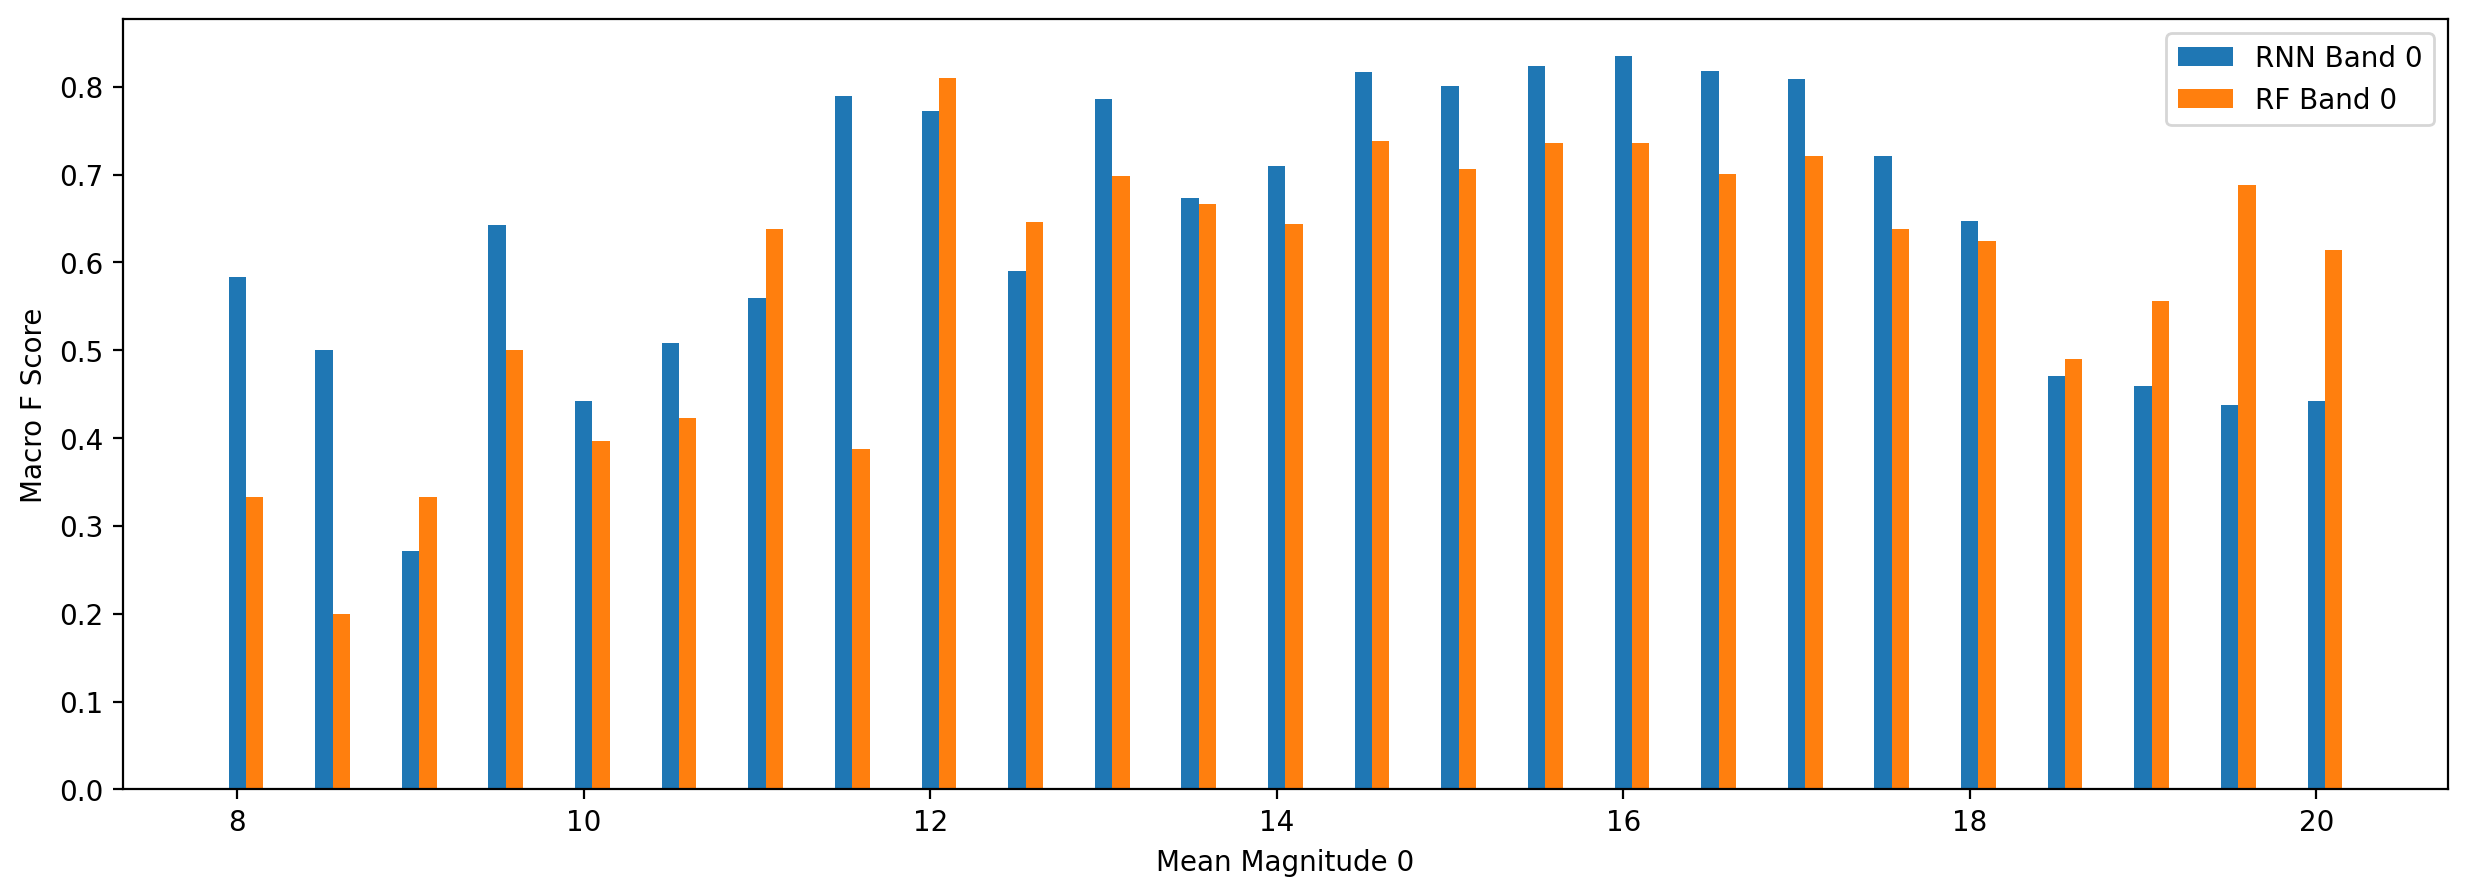

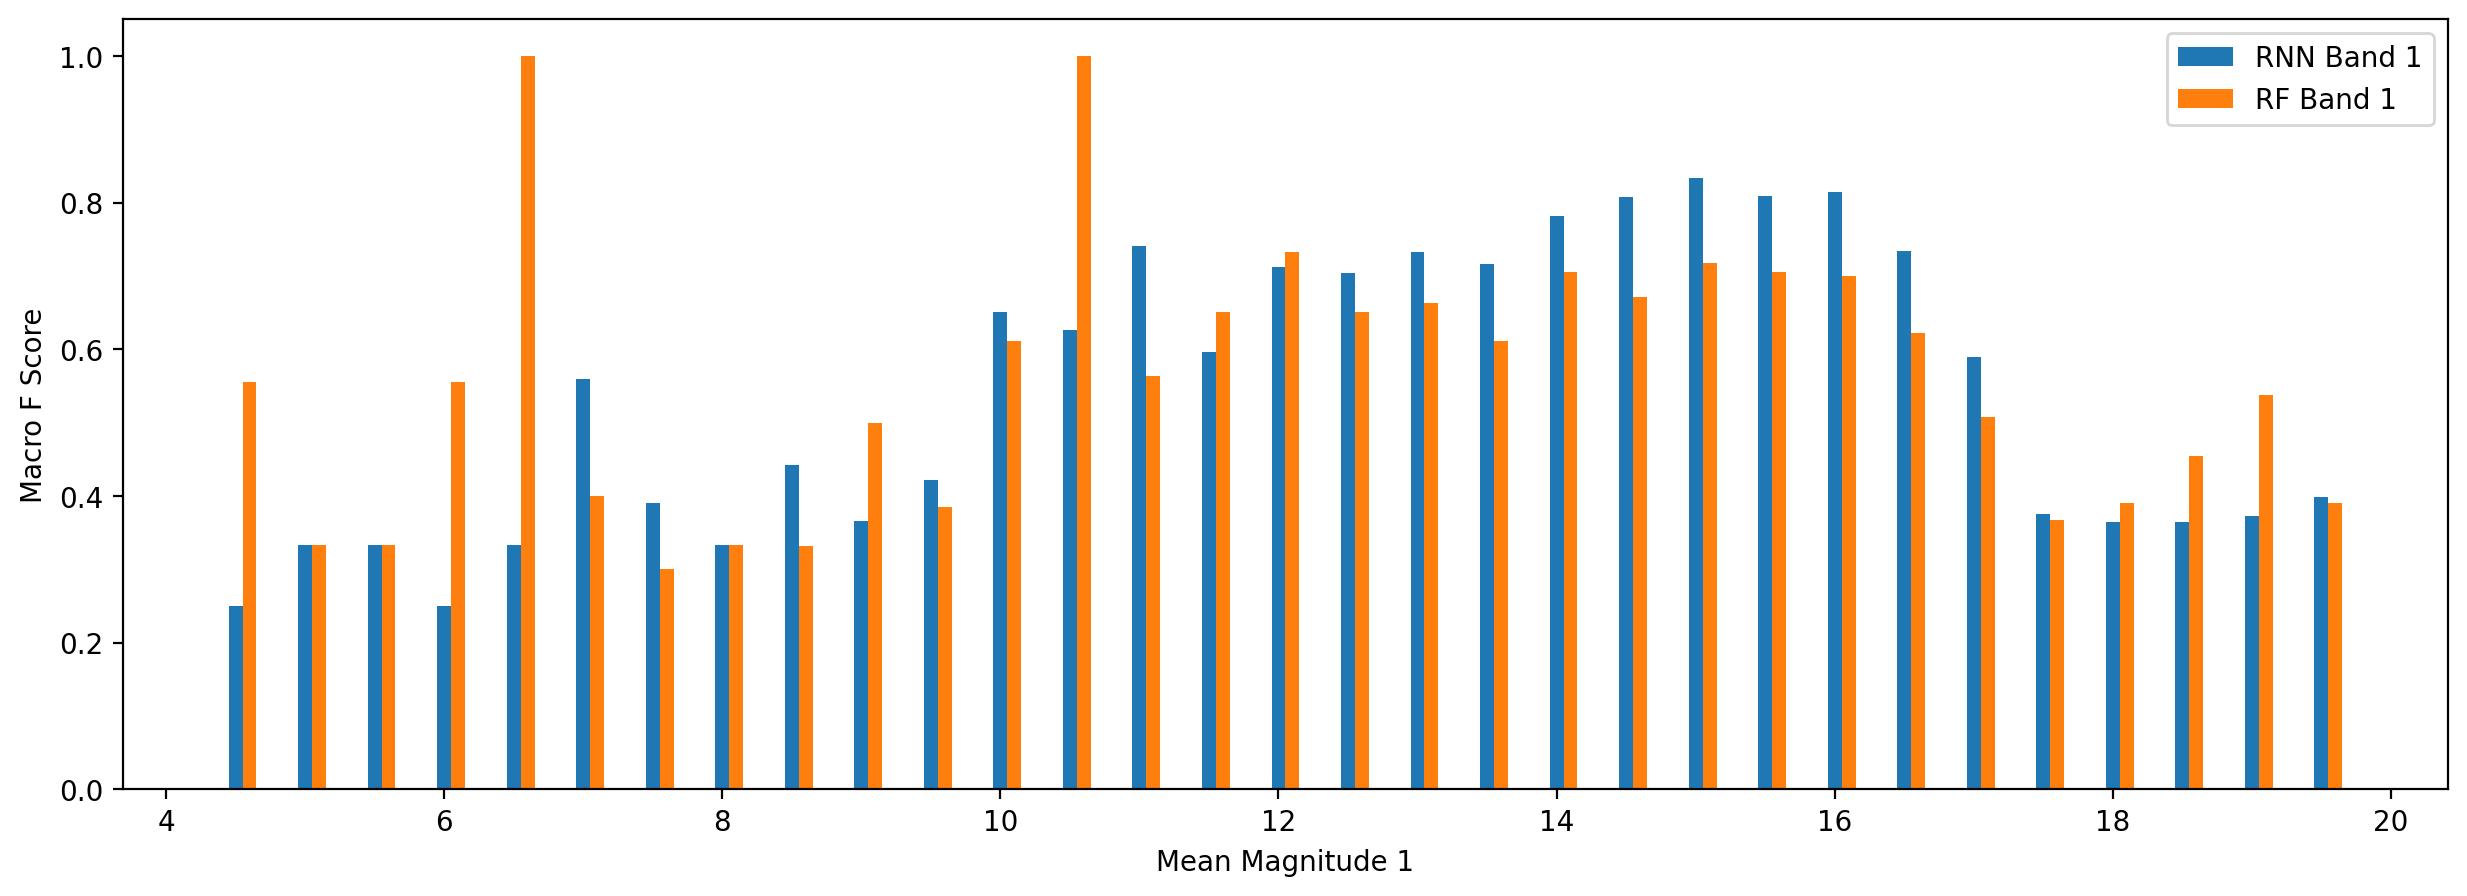

In [120]:

offset = {0:-0.25, 1:0.25}
for b in range(new.n_bands):
    plt.figure(figsize=(15,5), dpi=200)
    plt.bar(bins[b][:-1]-0.05, scores_rnn[b], width=0.1, label='RNN Band '+str(b), align='edge')
    plt.bar(bins[b][:-1]+0.05, scores_rf[b], width=0.1, label='RF Band '+str(b), align='edge')
    # plt.bar(bins[b][:-1]+0.05, scores_rnn[b], width=0.1, label='RNN Band '+str(b), align='edge')
    # break
    plt.xlabel('Mean Magnitude '+str(b))
    plt.ylabel('Macro F Score')
    plt.legend(loc=0)
    plt.show()

In [115]:
bins[0]

array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. ,
       13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5,
       19. , 19.5, 20. , 20.5])

In [ ]:
N

Do the same operations as in the model, to get exactly what we want.

In [ ]:
N = batch[0]['N_0'][0].numpy()
m0 = batch[0]['M0_0'][0].numpy()
data = batch[0]['input_LC_0'][0].numpy()[:N]
data

In [ ]:
tri_lower = np.tril(np.ones([N+1,N+1]),0)

# Third column and first delta of the third column
data1 = data[:,-1]
data0 = data[:1, 2]

data_ext = np.concatenate([data0, data1])

mags = np.matmul(tri_lower, data_ext)+m0

sum_mags = np.matmul(tri_lower, data_ext)+m0

sum_mags = sum_mags[1:]

N_obs = np.arange(3,N+3)

mean_mags_c = tf.divide(sum_mags, N_obs)

mean_mags[0]

Read the original file, in order to find the exact value

In [ ]:
df_lc = pd.read_csv('/home/Data/Databases/GAIA/Consolidate_Gaia/data_3/LCs/BP_RP_v3/'+batch[0]['ID'][0].numpy().decode()+'.dat')

b = df_lc.band==1
mags_file = df_lc[b].mag.values


for i in range(3,mags_file.shape[0]+1):
    print(i, np.round(mags_file[:i].sum()/(i), 6))
print('final mean mag ', np.round(mags_file.sum()/mags_file.shape[0], 6))

In [ ]:
mean_mag_tf

In [ ]:
mean_mag_tf= mean_mags[0].numpy()[:N+4]
for i in range(N):
    print(i+3, mean_mag_tf[i])
print('final mean mag ', mean_mag_tf[N-1]) # N-1 because we count from 0

In [ ]:
batch[0]['input_LC_0'][0].numpy()[:N]